In [ ]:
!conda install -y -c conda-forge pyarrow=16.0

In [3]:
# simglucose library -> 2adults, 2adolescent cohort. Random datas making
# save it 'uvapadova_raw.csv

import numpy as np
if not hasattr(np, "asscalar"):
    np.asscalar = lambda x: x.item()

import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

# simglucose imports
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.sim_engine import SimObj, batch_sim
from simglucose.controller.basal_bolus_ctrller import BBController

root = Path("silico_data"); root.mkdir(exist_ok=True)
raw_csv = root/"uvapadova_raw.csv"
raw_dir = root/"raw"; raw_dir.mkdir(exist_ok=True)

if raw_csv.exists():
    print("✔ uvapadova_raw.csv already exists, skipping simulation.")
else:
    cohort = ["adult#001","adult#002","adolescent#001","adolescent#002"]
    start_time = datetime(2025,1,1,0,0)
    sim_time   = timedelta(days=7)

    controller = BBController()
    sensor = CGMSensor.withName('Dexcom', seed=0)
    pump= InsulinPump.withName('Insulet')

    sim_objs = []
    for pid in cohort:
        patient  = T1DPatient.withName(pid)
        scenario = RandomScenario(start_time=start_time, seed=42)
        env = T1DSimEnv(patient, sensor, pump, scenario)
        sim_objs.append(
            SimObj(env, controller, sim_time, animate=False, path=str(raw_dir))
        )

    print("Starting serial simulation via batch_sim() …")
    df_list = batch_sim(sim_objs, parallel=False)
    print("Done simulation.")

    df = pd.concat(df_list, ignore_index=True)
    df.to_csv(raw_csv, index=False)
    print("✔ uvapadova_raw.csv 생성 완료:", df.shape)


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is depr

Starting serial simulation via batch_sim() …
Process ID: 18068
Simulation starts ...
Simulation Completed!
Process ID: 18068
Simulation starts ...


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]


Simulation Completed!
Process ID: 18068
Simulation starts ...


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]


Simulation Completed!
Process ID: 18068
Simulation starts ...


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]


Simulation Completed!
Simulation took 62.71709394454956 sec.
Done simulation.
✔ uvapadova_raw.csv 생성 완료: (13444, 7)


In [10]:
#use above data => Produce time datasets for machine learning.
#sliding window, Save x/y std , mean 
import numpy as np, pandas as pd, textwrap
from pathlib import Path

root = Path("silico_data")
raw_dir = root/"raw"

dfs = []
for fp in raw_dir.glob("*.csv"):
    df_one = pd.read_csv(fp)
    df_one["patient_id"] = fp.stem
    dfs.append(df_one)
df = pd.concat(dfs, ignore_index=True)

cols = df.columns.tolist()
lc= [c.lower() for c in cols]

bg_col = next((c for c in cols if c.lower() in ("cgm","glucose")), None)

cho_col = next((c for c in cols if c.lower() in ("cho","meal","carb")), None)

bolus_col = next((c for c in cols if "bolus" in c.lower() or ("insulin" in c.lower() and "basal" not in c.lower())), None)

basal_col = next((c for c in cols if "basal" in c.lower()), None)
if basal_col is None:
    basal_col = next((c for c in cols if "rate" in c.lower()), None)

if bg_col is None or cho_col is None:
    raise KeyError(f"BG({bg_col}) or CHO({cho_col}) 컬럼을 못 찾았습니다.")
print("Using → BG:", bg_col, "CHO:", cho_col,
      "Bolus:", bolus_col or "None→0", "Basal:", basal_col or "None→0")

PAST_LEN, FUTURE_LEN = 288, 144

def to_channels(sub):
    bg  = sub[bg_col].values
    cho = sub[cho_col].values / 15.0
    bol = sub[bolus_col].values if bolus_col else np.zeros_like(bg)
    bas = sub[basal_col].values if basal_col else np.zeros_like(bg)
    return np.stack([bg, cho, bol, bas], axis=1)

# 4) X, Y 쌓기
Xs, Ys = [], []
for pid, grp in df.groupby("patient_id"):
    sub = grp.reset_index(drop=True)
    for t in range(PAST_LEN, len(sub)-FUTURE_LEN):
        Xs.append( to_channels(sub.iloc[t-PAST_LEN:t]).astype("float32") )
        delta = sub[bg_col].iloc[t:t+FUTURE_LEN].values - sub[bg_col].iloc[t]
        Ys.append( delta.astype("float32").reshape(FUTURE_LEN,1) )

X = np.stack(Xs)
Y = np.stack(Ys)

np.save(root/"X_UV.npy", X)
np.save(root/"Y_UV.npy", Y)
np.save(root/"X_mean.npy", X.mean((0,1),keepdims=True))
np.save(root/"X_std.npy", X.std((0,1), keepdims=True))
np.save(root/"Y_mean.npy", Y.mean((0,1),keepdims=True))
np.save(root/"Y_std.npy", Y.std((0,1), keepdims=True))
print("💾 Saved X,Y shapes:", X.shape, Y.shape)

mod_path = Path("Silico_Datasets.py")
mod_path.write_text(textwrap.dedent(f"""
PAST_LEN   = {PAST_LEN}
FUTURE_LEN = {FUTURE_LEN}
import numpy as np
X  = np.load(r'{root/"X_UV.npy"}')
Y = np.load(r'{root/"Y_UV.npy"}')
X_mu = np.load(r'{root/"X_mean.npy"}')
X_std = np.load(r'{root/"X_std.npy"}')
Y_mu = np.load(r'{root/"Y_mean.npy"}')
Y_std = np.load(r'{root/"Y_std.npy"}')
"""))
print("✅ Silico_Datasets.py created")


Using → BG: CGM CHO: CHO Bolus: insulin Basal: None→0
💾 Saved X,Y shapes: (11716, 288, 4) (11716, 144, 1)
✅ Silico_Datasets.py created


In [12]:
# Call definition of Sugarnet

import torch
from model import SugarNet 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SugarNet(N=4, D=16, H=128, G=5).to(DEVICE)

state = torch.load("best_sugarnet.pt", map_location=DEVICE)
model.load_state_dict(state)

model.eval()
print("✔ 모델 로드 성공, H=128로 맞춤")


✔ 모델 로드 성공, H=128로 맞춤


In [19]:
#Zero-shot Silico Evaluation
#
import sys, os
import torch
import numpy as np
from sklearn.metrics import mean_squared_error

sys.path.insert(0, os.getcwd())
import Silico_Datasets as SD
sys.modules['Shanghai_Datasets'] = SD

from model import SugarNet
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SugarNet(N=4, D=16, H=128, G=5).to(DEVICE)
state = torch.load("best_sugarnet.pt", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

import torch.utils.data as td

N_SAMPLES = 1000
X = SD.X[:N_SAMPLES] # shape (N, 288, 4)
Y = SD.Y[:N_SAMPLES].squeeze(-1) # shape (N, 144)

BG_base = X[:, -1, 0]

ds     = td.TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
loader = td.DataLoader(ds, batch_size=8, shuffle=False, pin_memory=True)

preds, trues = [], []
with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        preds.append(out.cpu().numpy())
        trues.append(yb.numpy())
        if DEVICE.type=='cuda':
            torch.cuda.empty_cache()

preds = np.vstack(preds)
trues = np.vstack(trues)
rmse = np.sqrt(mean_squared_error(trues.ravel(), preds.ravel()))
BG_pred = BG_base[:,None] + preds  # (N,144)
BG_true = BG_base[:,None] + trues
mard = np.mean( np.abs(BG_pred - BG_true) / BG_true ) * 100

print(f"[Zero‑shot Silico] RMSE (ΔBG): {rmse:.2f} mg/dL")
print(f"[Zero‑shot Silico] MARD (absolute BG): {mard:.2f} %")


[Zero‑shot Silico] RMSE (ΔBG): 27.37 mg/dL
[Zero‑shot Silico] MARD (absolute BG): 13.76 %


In [ ]:
#이 결과는 전체 144스텝(12시간)예측으로, 모든 슬라이딩 윈도우에 대해 대략적으로 계산한 오차.
#전체 평균 RMSE, MARD, 즉 144스텝 모든 윈도우에 대해 평균

In [24]:


from simglucose.controller.base import Controller
import torch

class MySugarNetController(Controller):
    def __init__(self, model, device):
        super().__init__(init_state=(0.0, 0.0))

        self.model = model.to(device)
        self.device = device

    def policy(self, obs, reward, done, **info):
        arr  = obs[['CGM','CHO','Bolus','Basal']].values  # (T,4)
        x = torch.tensor(arr[None,...], dtype=torch.float32).to(self.device)
        with torch.no_grad():
            delta = self.model(x).cpu().numpy().reshape(-1)
        insulin_u = float(max(0.0, delta.sum() * 0.01))

        return insulin_u


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is depr

Process ID: 23232
Simulation starts ...
Simulation Completed!
Process ID: 23232
Simulation starts ...


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]


Simulation Completed!
Simulation took 27.611534118652344 sec.
TIR   (70–180 mg/dL): 87.2%
Hypo  (< 70 mg/dL):   0.0%
Hyper (> 180 mg/dL): 12.8%


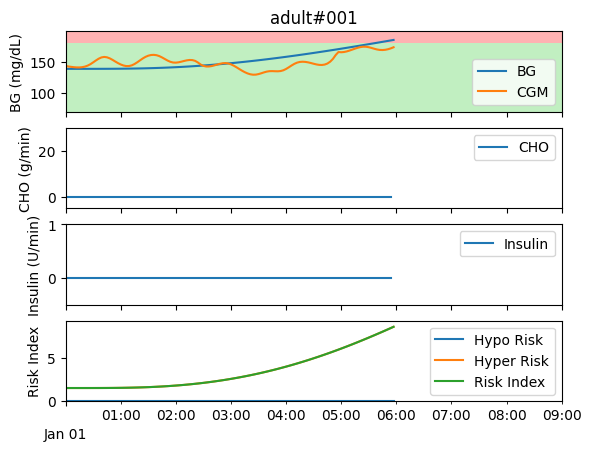

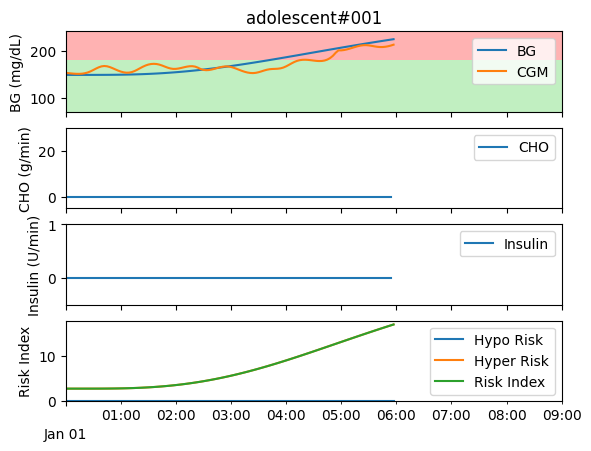

In [5]:
#closed-loop simulation
# Use mysugarnetController - RandomScenario->batch->results  according to the Silico paper
#This is first version of closed-loop
# Next cell is the final closed-loop

from datetime import datetime, timedelta
import os, gc, torch, pandas as pd

from simglucose.patient.t1dpatient  import T1DPatient
from simglucose.sensor.cgm  import CGMSensor
from simglucose.actuator.pump   import InsulinPump
from simglucose.simulation.env    import T1DSimEnv
from simglucose.simulation.sim_engine  import SimObj, batch_sim
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.controller.base   import Action

from model import SugarNet

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SugarNet(N=4, D=16, H=128, G=5).to(DEVICE)
state = torch.load("best_sugarnet.pt", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

class MySugarNetController:
    def __init__(self, model, device, past_len=288):
        self.model    = model
        self.dev      = device
        self.PAST_LEN = past_len
        self.hist     = []

    def policy(self, obs, reward, done, **info):
        cgm = float(getattr(obs, "CGM", 0.0))
        cho  = float(info.get("meal", 0.0))
        bol  = float(info.get("bolus", 0.0))
        bas  = float(info.get("basal", info.get("rate", 0.0)))
        self.hist.append([cgm, cho/15.0, bol, bas])

        if len(self.hist) < self.PAST_LEN:
            return Action(basal=0.0, bolus=0.0)

        x = torch.tensor([self.hist[-self.PAST_LEN:]],
                         dtype=torch.float32, device=self.dev)
        with torch.no_grad():
            delta = self.model(x).cpu().item()

        target = 110.0
        u = max((cgm + delta - target) / 50.0, 0.0)
        return Action(basal=u, bolus=0.0)


os.makedirs("results", exist_ok=True)

cohort       = ["adult#001", "adolescent#001"]
sim_duration = timedelta(minutes=6*60) 
seed         = 42

sim_objs = []
for pid in cohort:
    patient  = T1DPatient.withName(pid)
    sensor   = CGMSensor.withName("Dexcom", seed=seed)
    pump     = InsulinPump.withName("Insulet")
    ctrl     = MySugarNetController(model, DEVICE)
    scenario = RandomScenario(start_time=datetime(2020,1,1), seed=seed)
    env      = T1DSimEnv(patient, sensor, pump, scenario)
    sim_objs.append(SimObj(env, ctrl, sim_duration, path="results"))

results = batch_sim(sim_objs, parallel=False)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

df_all = pd.concat([pd.read_csv(f"results/{pid}.csv") for pid in cohort],
                      ignore_index=True)
tir = ((df_all.CGM >= 70) & (df_all.CGM <= 180)).mean() * 100
hypo_rate = (df_all.CGM < 70).mean()  * 100
hyper_rate = (df_all.CGM > 180).mean() * 100

print(f"TIR   (70–180 mg/dL): {tir:.1f}%")
print(f"Hypo  (< 70 mg/dL):   {hypo_rate:.1f}%")
print(f"Hyper (> 180 mg/dL): {hyper_rate:.1f}%")


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is depr

Process ID: 23232
Simulation starts ...
Simulation Completed!
Process ID: 23232
Simulation starts ...


/home/krg/miniconda3/envs/efficient-kan-KyungHwan/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]


Simulation Completed!
Simulation took 27.615869760513306 sec.
TIR   (70–180 mg/dL): 87.2%
Hypo  (< 70 mg/dL):   0.0%
Hyper (> 180 mg/dL): 12.8%


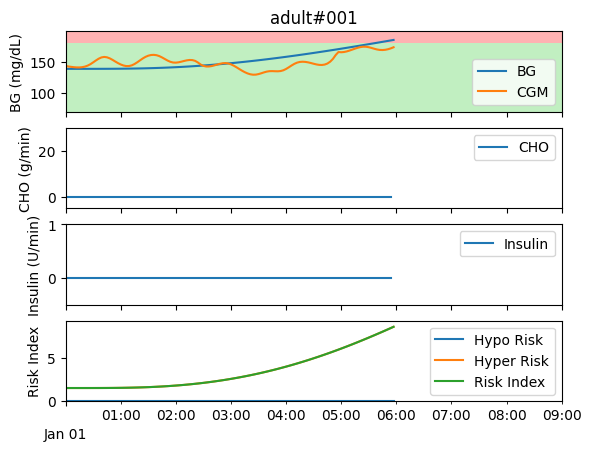

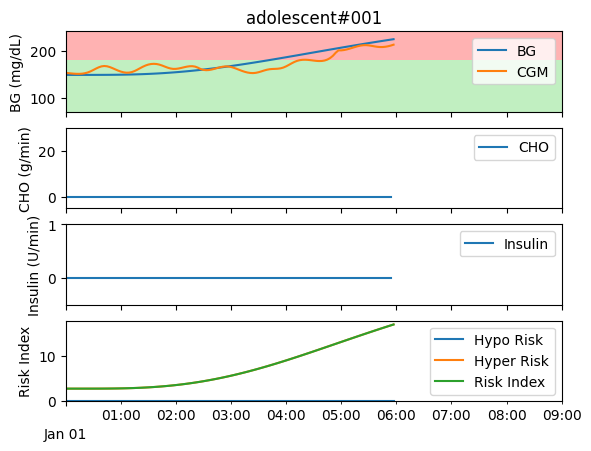

In [10]:
#Meal event...and so on is including. but not sure it works well
#because below graphs don't represent move of CHO and Insulin
#Such events are depending on basic seeting of RandomScenario

from datetime import datetime, timedelta
import os, gc, torch, pandas as pd, numpy as np
from simglucose.patient.t1dpatient   import T1DPatient
from simglucose.sensor.cgm   import CGMSensor
from simglucose.actuator.pump  import InsulinPump
from simglucose.simulation.env   import T1DSimEnv
from simglucose.simulation.sim_engine   import SimObj, batch_sim
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.controller.base         import Controller, Action
from model  import SugarNet

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = SugarNet(N=4, D=16, H=128, G=5).to(DEVICE)
state  = torch.load("best_sugarnet.pt", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

class MySugarNetController(Controller):
    def __init__(self, model, device, past_len=288, future_len=144, sens=1.0):
        super().__init__(init_state=[0.0]*4)
        self.model = model
        self.device = device
        self.PAST_LEN  = past_len
        self.FUTURE_LEN  = future_len
        self.sensitivity = sens
        self.hist  = []

    def policy(self, obs, reward, done, **info):
        cgm  = float(obs[0])
        cho = float(info.get("CHO", 0.0))
        if self.hist:
            prev_bolus = self.hist[-1][2]
            prev_basal = self.hist[-1][3]
        else:
            prev_bolus = 0.0
            prev_basal = 0.0
        self.hist.append([cgm, cho/15.0, prev_bolus, prev_basal])
        if len(self.hist) < self.PAST_LEN:
            return Action(basal=prev_basal, bolus=0.0)
        arr = np.array(self.hist[-self.PAST_LEN:], dtype=np.float32)
        X   = torch.from_numpy(arr[None,...]).to(self.device)
        with torch.no_grad():
            dBG = self.model(X).cpu().numpy().reshape(-1)
        max_dBG = dBG.max()
        if max_dBG <= 0:
            return Action(basal=prev_basal, bolus=0.0)
        bolus_u = float(np.clip(max_dBG / self.sensitivity, 0, 10))
        return Action(basal=prev_basal, bolus=bolus_u)

os.makedirs("results", exist_ok=True)

cohort       = ["adult#001", "adolescent#001"]
sim_duration = timedelta(minutes=6*60)
seed         = 42

sim_objs = []
for pid in cohort:
    patient  = T1DPatient.withName(pid)
    sensor= CGMSensor.withName("Dexcom", seed=seed)
    pump = InsulinPump.withName("Insulet")
    ctrl = MySugarNetController(model, DEVICE)
    scenario = RandomScenario(start_time=datetime(2020,1,1), seed=seed)
    env = T1DSimEnv(patient, sensor, pump, scenario)
    sim_objs.append(SimObj(env, ctrl, sim_duration, path="results"))

results = batch_sim(sim_objs, parallel=False)

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

df_all  = pd.concat([pd.read_csv(f"results/{pid}.csv") for pid in cohort], ignore_index=True)
tir   = ((df_all.CGM   >= 70) & (df_all.CGM   <= 180)).mean() * 100
hypo_rate  = ( df_all.CGM   <  70).mean() * 100
hyper_rate = ( df_all.CGM   > 180).mean() * 100

print(f"TIR   (70–180 mg/dL): {tir:.1f}%")
print(f"Hypo  (< 70 mg/dL):   {hypo_rate:.1f}%")
print(f"Hyper (> 180 mg/dL): {hyper_rate:.1f}%")
